In [1]:
import torch
import torch.nn as nn
from torchsummary import summary
import torchvision
from tqdm.auto import tqdm

import matplotlib.pyplot as plt   

import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# force re-import
%load_ext autoreload
%autoreload 2



/home/kbh/.conda/envs/dnn/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Hypter parameters

In [2]:
lastdigit=4
device = "cuda:0"
type_model = "DNN" # DNN, CNN

modelsave_path = "."

batch_size = 512
num_workers = 16
num_epochs = 10
lr = 1e-4

# Models

In [3]:
class model_DNN(nn.Module):
    def __init__(self, input_size=28*28,output_size=9):
        super(model_DNN, self).__init__()
        
        self.dropout=nn.Dropout(0.2)
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 9)
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # flatten
        B,C,W,H = x.shape
        x = torch.reshape(x,(B,C,W*H))
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        x = self.dropout(x)
        out = self.softmax(x[:,0])
        return out
    
class model_CNN(nn.Module):
    def __init__(self, output_size=9):
        super(model_CNN, self).__init__()
        self.relu = nn.ReLU()
        
        self.conv1 = nn.Conv2d(1,32,(3,3))
        self.conv2 = nn.Conv2d(32,32,(3,3))
        self.maxpool = nn.MaxPool2d((2,2))
        
        
        self.fc1 = nn.Linear(4608, 128)
        self.fc2 = nn.Linear(128, 9)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        out = self.softmax(x)
        return out

# Data

In [4]:
dataset_train = torchvision.datasets.MNIST(root = './data/',
                            train=True,
                            download=True,
                            transform=torchvision.transforms.ToTensor())
dataset_test = torchvision.datasets.MNIST(root = './data/',
                            train=False,
                            download=True,
                            transform=torchvision.transforms.ToTensor())

print("train : {} | test : {}".format(len(dataset_train),len(dataset_test)))

indices_train = [idx for idx, target in enumerate(dataset_train.targets) if target != lastdigit]
indices_test = [idx for idx, target in enumerate(dataset_test.targets) if target != lastdigit]

print("Filter by lastdigit {}".format(lastdigit))

dataset_train = torch.utils.data.Subset(dataset_train,indices_train)
dataset_test = torch.utils.data.Subset(dataset_test,indices_test)

print("train : {} | test : {}".format(len(dataset_train),len(dataset_test)))

loader_train = torch.utils.data.DataLoader(dataset=dataset_train,batch_size=batch_size,shuffle=True,num_workers=num_workers,pin_memory=True)
loader_test = torch.utils.data.DataLoader(dataset=dataset_test,batch_size=batch_size,shuffle=True,num_workers=num_workers,pin_memory=True)



train : 60000 | test : 10000
Filter by lastdigit 4
train : 54158 | test : 9018


# Train routines

In [5]:
def run(
    data,
    model,
    criterion=None,
    ret_output=False,
    device="cuda:0"
    ): 
    feature = data[0].to(device)
    
    estim = model(feature)
    
    # lastdigit adjust,
    label = torch.where(data[1] > lastdigit , data[1]-1, data[1]).to(device)
    target = nn.functional.one_hot(label,num_classes=9).to(torch.float32)
                                   
    if criterion is None : 
        return estim
    loss = criterion(estim,target)
        
    if ret_output :
        T = (label == estim.argmax(dim=1)).sum()
        F = (label != estim.argmax(dim=1)).sum()
        return (T,F), loss
    else : 
        return loss


In [6]:
def train(type_model) : 
    if type_model == "DNN" : 
        model = model_DNN()
    elif type_model == "CNN" : 
        model = model_CNN()
    else :
        raise Exception("ERROR::Unknown model {}".format(type_model))
    summary(model,(1,28,28),device = "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

    log_train = []
    log_test  = []
    log_acc   = []

    best_loss = 1e13

    for epoch in tqdm(range(num_epochs)):
        model.train()
        train_loss = 0.0
        for i, data in enumerate(loader_train):
            loss = run(data,model,criterion,device=device)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        train_loss = train_loss/len(loader_train)
        torch.save(model.state_dict(), str(modelsave_path)+'/{}_lastmodel.pt'.format(type_model))

        log_train.append(train_loss)

        model.eval()
        with torch.no_grad():
            test_loss =0.
            acc_T = 0
            acc_F = 0
            for j, (data) in enumerate(loader_test):
                (T,F), loss = run(data,model,criterion,ret_output=True,device=device)
                test_loss += loss.item()
                acc_T += T
                acc_F += F

            test_loss = test_loss/len(loader_test)
            scheduler.step(test_loss)

            if best_loss > test_loss:
                torch.save(model.state_dict(), str(modelsave_path)+'/{}_bestmodel.pt'.format(type_model))
                best_loss = test_loss

        log_test.append(test_loss)
        log_acc.append((acc_T/(acc_T+acc_F)).to('cpu'))

    plt.figure()
    plt.plot(log_train)
    plt.title("train loss")

    plt.figure()
    plt.plot(log_test)
    plt.title("test loss")

    plt.figure()
    plt.plot(log_acc)
    plt.title("accuracy : {}".format(max(log_acc)))
    print(log_acc)
    
    return model
    
    

In [7]:
def eval(model) : 
    confusion = np.zeros((9,9))

    confusion_axis = list(range(10))
    confusion_axis.remove(lastdigit)

    idx_plot = 1
    n_plot = 5
    do_sample = True

    plt.figure()
    plt.figure(figsize=(6, 6))
    for data,label in tqdm(dataset_test) : 
        data = data.to(device)


        x = torch.unsqueeze(data,dim=0)

        estim = model(x)
        estim = (estim.argmax(dim=1)).detach().cpu().numpy()[0]

        if label >= lastdigit :
            label -=1
        confusion[label,estim]+=1

        if label != estim and do_sample :

            plt.subplot(n_plot,n_plot,idx_plot)
            plt.imshow(data[0].cpu().numpy(),cmap='gray_r')
            plt.axis('off')

            if estim >= lastdigit :
                act_estim = estim+1
            else : 
                act_estim = estim

            if label >= lastdigit :
                act_label = label+1
            else : 
                act_label = label            
            plt.title("T{} E{}".format(act_label,act_estim))
            idx_plot+=1

            if idx_plot == n_plot * n_plot :
                do_sample = False

    df_cm = pd.DataFrame(confusion, 
                      index = confusion_axis,
                      columns = confusion_axis)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)

    plt.xlabel("Pred")
    plt.ylabel("True")

# Train

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         200,960
              ReLU-2               [-1, 1, 256]               0
           Dropout-3               [-1, 1, 256]               0
            Linear-4               [-1, 1, 128]          32,896
              ReLU-5               [-1, 1, 128]               0
           Dropout-6               [-1, 1, 128]               0
            Linear-7                 [-1, 1, 9]           1,161
           Dropout-8                 [-1, 1, 9]               0
           Softmax-9                    [-1, 9]               0
Total params: 235,017
Trainable params: 235,017
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.90
Estimated Total Size (MB): 0.91
-------------------------------------------

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:39<00:00,  4.00s/it]


[tensor(0.6504), tensor(0.8551), tensor(0.8930), tensor(0.9040), tensor(0.9096), tensor(0.9139), tensor(0.9165), tensor(0.9216), tensor(0.9245), tensor(0.9264)]


100%|███████████████████████████████████████████████████████████████████████████| 9018/9018 [00:15<00:00, 576.01it/s]


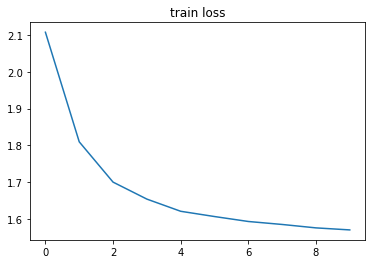

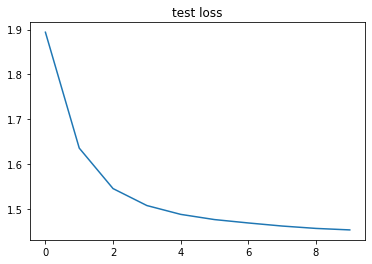

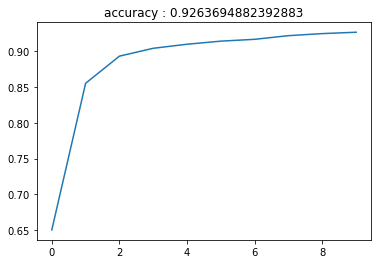

<Figure size 432x288 with 0 Axes>

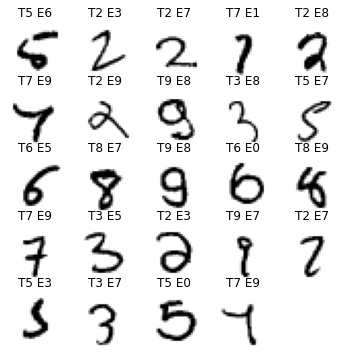

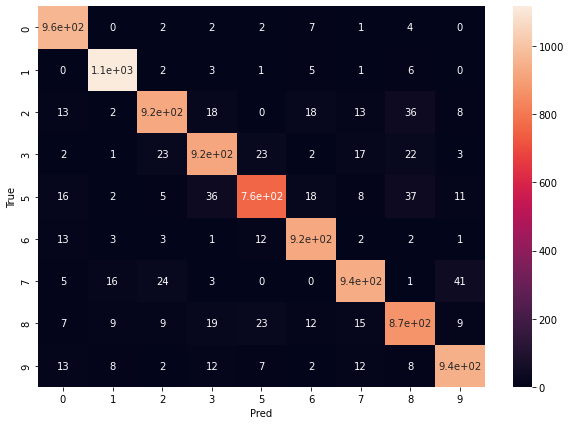

In [8]:
model = train("DNN")
eval(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 32, 24, 24]           9,248
              ReLU-4           [-1, 32, 24, 24]               0
         MaxPool2d-5           [-1, 32, 12, 12]               0
            Linear-6                  [-1, 128]         589,952
              ReLU-7                  [-1, 128]               0
            Linear-8                    [-1, 9]           1,161
           Softmax-9                    [-1, 9]               0
Total params: 600,681
Trainable params: 600,681
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.65
Params size (MB): 2.29
Estimated Total Size (MB): 2.94
-------------------------------------------

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:47<00:00,  4.78s/it]


[tensor(0.7950), tensor(0.8348), tensor(0.9117), tensor(0.9208), tensor(0.9286), tensor(0.9352), tensor(0.9381), tensor(0.9417), tensor(0.9460), tensor(0.9497)]


100%|███████████████████████████████████████████████████████████████████████████| 9018/9018 [00:18<00:00, 500.52it/s]


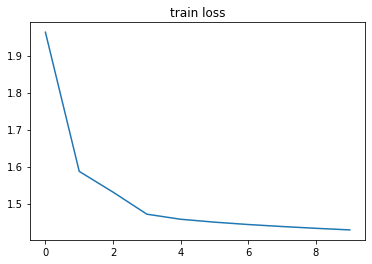

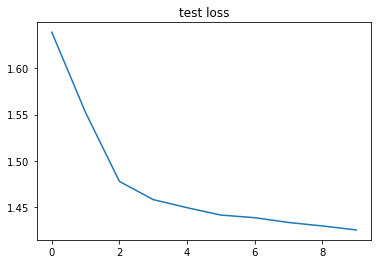

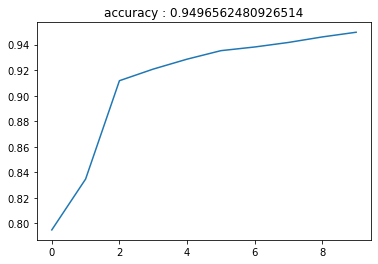

<Figure size 432x288 with 0 Axes>

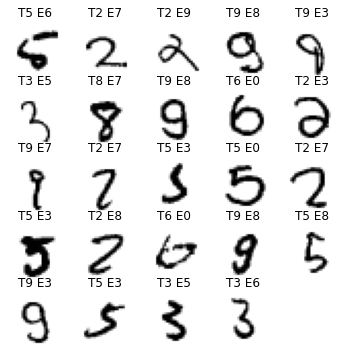

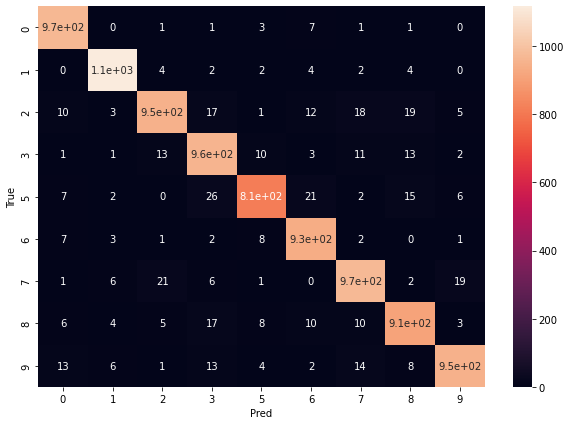

In [9]:
model = train("CNN")
eval(model)